# <center> **Filtragem no Dominio da Frequência**

## **1. Importing data from Google Drive**

In [1]:
# Montando o drive 
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd drive/MyDrive/Processamento Digital de Imagem

[Errno 2] No such file or directory: 'drive/MyDrive/Processamento Digital de Imagem'
/content/drive/MyDrive/Processamento Digital de Imagem
/content/drive/MyDrive/Processamento Digital de Imagem/Filtragem no Dominio de Frequência


In [4]:
%cd Filtragem no Dominio de Frequência

'Filtragem no dominio da Frequência.ipynb'   images


## **2. Importing necessary libraries**

In [5]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image # Import grayscale images

## **3. Importing and testing images**

In [ ]:
"""img = cv.imread('images/motoko.jpg', cv.IMREAD_GRAYSCALE)

cv.imshow('image',img)

cv.waitKey(0)
cv.destroyAllWindows()"""

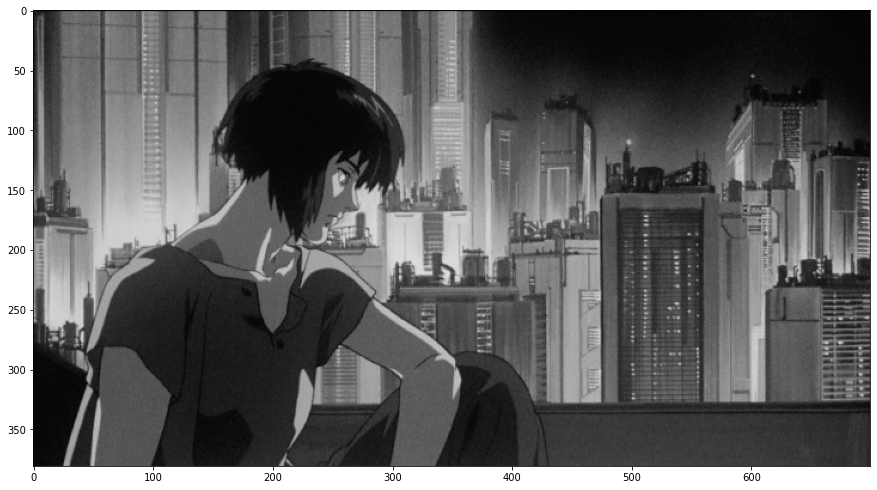

In [6]:
# Ploting in grayscale with matplotlib #
fname = 'images/motoko.jpg'
image = Image.open(fname).convert("L")
arr = np.asarray(image)

plt.figure(figsize=(15,10))
plt.imshow(arr, cmap='gray', vmin=0, vmax=255)

plt.show()

## **4. Transformada Discreta de Fourier**

### **Funções Auxiliares**

In [7]:
# Função auxiliar para trocar as regiões #

# Function to swap quadrants #
def swapQ(img):
    img_copy = img.copy()

    height, width = img_copy.shape
    img_copy = img_copy[0:(height & -2), 0:(width & -2)]

    h = int(height/2)
    w = int(width/2)

    # Quatrants #

    q0 = img_copy[0:h, 0:w]       
    q1 = img_copy[h:h+h, 0:w]    
    q2 = img_copy[0:h, w:w+w]     
    q3 = img_copy[h:h+h, w:w+w] 

    # Swaping #

    tmp = np.copy(q0)
    img_copy[0:h, 0:w] = q3
    img_copy[h:h+h, w:w + w] = tmp
    tmp = np.copy(q1) 
    img_copy[h:h + h, 0:w] = q2
    img_copy[0:h, w:w + w] = tmp
    
    return img_copy

### **4.1 Getting optimal size**

The DFT is directly dependent to the size of the image, so we must find the best size for the image, generally the best size is multiple of two, three or five. To get the optimal size will be used `getOptimalDFTSize.()` function. After getting best size, it will be added a padding to the image with `copyMakeBorder()`.

In [8]:
img = cv.imread('images/yuu.jpg', cv.IMREAD_GRAYSCALE)

height = img.shape[0]
width = img.shape[1]

m = cv.getOptimalDFTSize(height)
n = cv.getOptimalDFTSize(width)

img_pad = cv.copyMakeBorder(img, 0, m - height, 0, n - width, cv.BORDER_CONSTANT, value=[0, 0, 0])

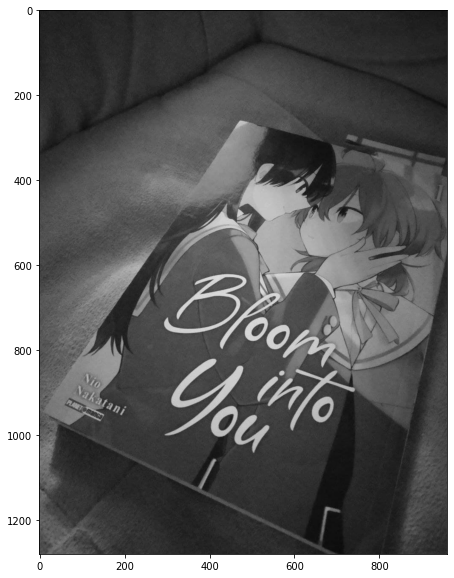

In [13]:
fname = 'images/yuu.jpg'
image = Image.open(fname).convert("L")
arr = np.asarray(image)

plt.figure(figsize=(10,10))
plt.imshow(arr, cmap='gray', vmin=0, vmax=255)

plt.show()

### **4.2 Applying DFT and getting Real plane**

In [9]:
planes = [np.float32(img_pad), np.zeros(img_pad.shape, np.float32)]
complex_img = cv.merge(planes)         # Add to the expanded another plane with zeros

In [10]:
# Applying DFT #
cv.dft(complex_img, complex_img)         # this way the result may fit in the source matrix

# Getting the REAL plane #
cv.split(complex_img, planes)                   # planes[0] = Re(DFT(I), planes[1] = Im(DFT(I))
cv.magnitude(planes[0], planes[1], planes[0])   # planes[0] = magnitude
magI = planes[0]

### **4.3 Logaritmic Scale and Normalizing**

In [11]:
matOfOnes = np.ones(magI.shape, dtype=magI.dtype)
cv.add(matOfOnes, magI, magI) #  switch to logarithmic scale
cv.log(magI, magI)

# Swap #
magI = swapQ(magI)

# Normalize #
cv.normalize(magI, magI, 0, 255, cv.NORM_MINMAX) # Transform the matrix with float values into a

# Saving image ##
cv.imwrite('images/magImage.jpg', magI)

True

In [ ]:
"""print(magI)
cv.imwrite('images/magImage.jpg', magI)
cv.imshow('image',magI)

cv.waitKey(0)
cv.destroyAllWindows()"""

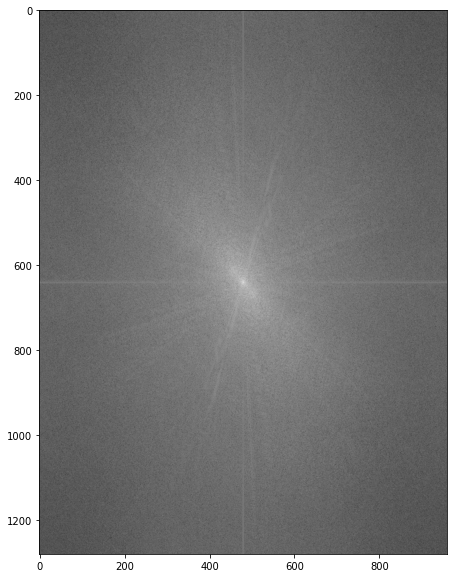

In [12]:
# Ploting in grayscale with matplotlib #
fname = 'images/magImage.jpg'
image = Image.open(fname).convert("L")
arr = np.asarray(image)

plt.figure(figsize=(10,10))
plt.imshow(arr, cmap='gray', vmin=0, vmax=255)

plt.show()

### **4.4 Fast way with numpy**

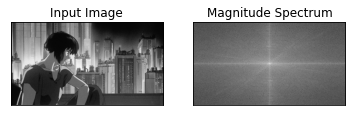

In [14]:
img = cv.imread('images/motoko.jpg', cv.IMREAD_GRAYSCALE)

f = np.fft.fft2(img) # calcula a dft
fshift = np.fft.fftshift(f) # coloca no centro
magnitude_spectrum = 20*np.log(np.abs(fshift))
plt.subplot(121),plt.imshow(img, cmap = 'gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(magnitude_spectrum, cmap = 'gray')
plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])
plt.show()

## **5. Filtrando com DFT**

Uma das grandes utilizades de passarmos uma função para ao dominio da frequência é podermos manipular facilmente os valores, como por exemlo limitarmos as componentes de alta ou baixa frequência. O mesmo se estende para as imagens, onde podemos gerar um detector de bordas ou borrar a imagem.

### **5.1 Filtro Passa-Baixa**

1. Ao calcular a dft usando `cv.dft()` foi realizado a troca de quadrantes utilizando `np.fft.fftshift()` e o valor é colocado em `img_dft`.

2. Para criar o filtro, foi gerado uma máscara do mesmo tamanho que a imagem que foi aplicada a dft. Essa máscara inicialmente todos os valores estão em zero, é colocado **1** em todos aqueles pixels em um certo raio dado pelo parâmetro `tresh` (também conhecido como frequência de corte) para retirar as componentes de alta frequência.

3. É feito uma multiplicação pixel a com img_dft com a máscara gerada. Em seguida é feito novamente a troca de quadrantes para assim calcular a dft inversa.

4. Por fim é calculado a magnetude da img para obter o resultado final.

**Importante!!** é importante a manipulação dos tipos de variaveis (float32, uint8..) para que o algoritmo funcione!

In [15]:
img = cv.imread('images/motoko.jpg', cv.IMREAD_GRAYSCALE)

In [16]:
def low_pass(img, tresh):
    
    img_dft = cv.dft(np.float32(img), flags=cv.DFT_COMPLEX_OUTPUT)
    img_dft = np.fft.fftshift(img_dft)

    magnetude = cv.magnitude(img_dft[:, :, 0], img_dft[:, :, 1])
    magnetude_spectrum = 20 * np.log(magnetude)

    height = img.shape[0]
    width = img.shape[1]

    m = (height/2)
    n = (width/2)

    # Creating a mask for low-pass filter #
    tmp = np.zeros((height, width, 2), dtype=np.float32)

    for i in range(height):
        for j in range(width):
            if (i-m)*(i-m)+(j-n)*(j-n) < tresh*tresh:
                tmp[i][j] = 1

    fshift = img_dft * tmp
    f_ishift = np.fft.ifftshift(fshift)
    img_back = cv.idft(f_ishift)
    img_back = cv.magnitude(img_back[:, :, 0], img_back[:, :, 1])
    img_back = img_back.astype(np.float32)

    return img_back

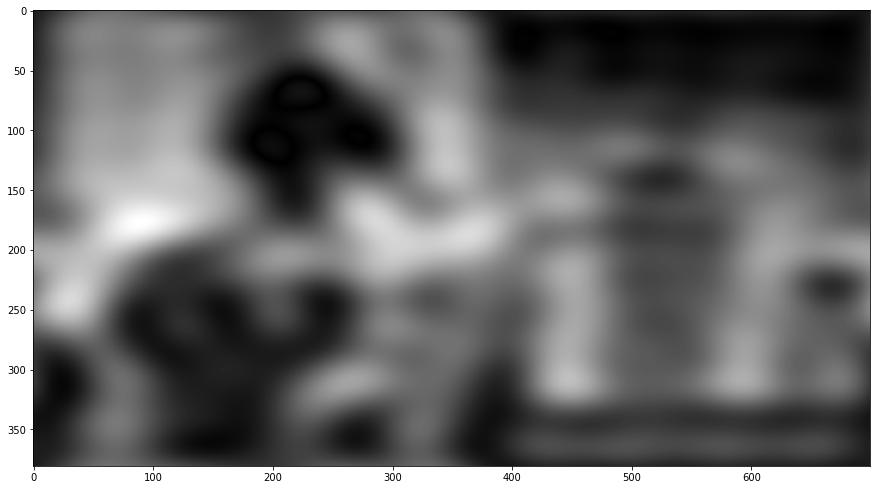

In [17]:
img_filtered = low_pass(img, 10)
f, ax = plt.subplots(figsize=(15,10))

plt.imshow(img_filtered, cmap='gray')

plt.show()

### **5.2 Filtro Passa-Alta**

O Filtro Passa-Alta funciona da mesma forma que o Passa-Baixas, a diferênça é que aqui ele só deixa passar frequências altas, e as baixas são ignoradas

In [18]:
img = cv.imread('images/motoko.jpg', cv.IMREAD_GRAYSCALE)

In [19]:
def high_pass(img, tresh):
    
    img_copy = img.copy()
    
    img_dft = cv.dft(np.float32(img_copy), flags=cv.DFT_COMPLEX_OUTPUT)
    img_dft = np.fft.fftshift(img_dft)

    magnetude = cv.magnitude(img_dft[:, :, 0], img_dft[:, :, 1])
    magnetude_spectrum = 20 * np.log(magnetude)

    height = img.shape[0]
    width = img.shape[1]

    m = (height/2)
    n = (width/2)

    # Creating a mask for low-pass filter #
    tmp = np.zeros((height, width, 2), dtype=np.float32)

    for i in range(height):
        for j in range(width):
            if (i-m)*(i-m)+(j-n)*(j-n) > tresh*tresh:
                tmp[i][j] = 1

    fshift = img_dft * tmp
    f_ishift = np.fft.ifftshift(fshift)
    img_back = cv.idft(f_ishift)
    
    img_back = cv.magnitude(img_back[:, :, 0], img_back[:, :, 1])
    img_back = img_back.astype(np.float32)

    return img_back

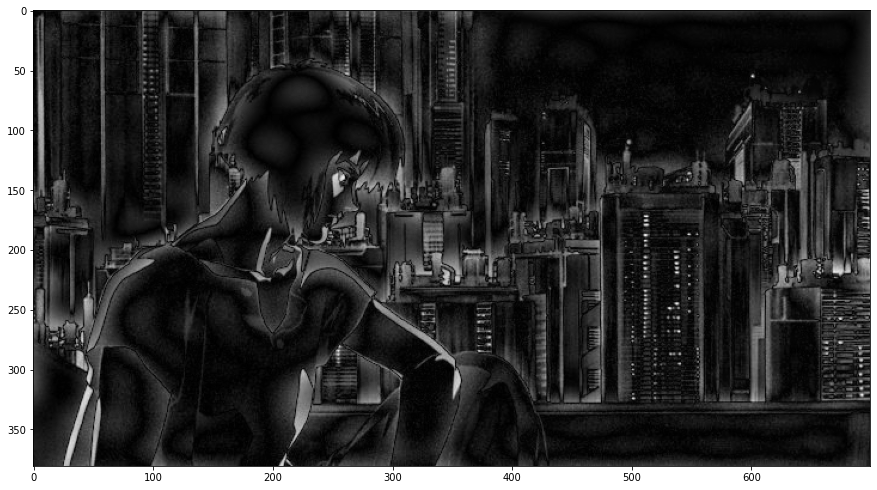

In [20]:
img_filtered = high_pass(img, 10)
f, ax = plt.subplots(figsize=(15,10))

plt.imshow(img_filtered, cmap='gray')

plt.show()

## **6. Exercicio 1: Filtro Homomoforfico**

Nesse tipo de filtro, a diferença é que a geração da máscara é dada de um processo diferente. A equação para a geração das máscara é a seguinte:

\begin{align}
        H(u, v) = (l1 - l2)[1 - \mathrm{e}^{-c[\frac{D^2(u, v)}{D0^2}]}] + l2
    \end{align}

Onde `l1` e `l2` são as frequências de corte. `c` e `d0` são constantes. 


In [21]:
img = cv.imread('images/motoko.jpg', cv.IMREAD_GRAYSCALE)

In [22]:
def homo_filter(img, tresh1, tresh2, c, d0):
    
    img_copy = img.copy()
    
    img_dft = cv.dft(np.float32(img), flags=cv.DFT_COMPLEX_OUTPUT)
    img_dft = np.fft.fftshift(img_dft)

    magnetude = cv.magnitude(img_dft[:, :, 0], img_dft[:, :, 1])
    magnetude_spectrum = 20 * np.log(magnetude)

    height = img.shape[0]
    width = img.shape[1]

    m = (height/2)
    n = (width/2)

    # Creating a mask for low-pass filter #
    tmp = np.zeros((height, width, 2), dtype=np.float32)

    for i in range(height):
        for j in range(width):
            tmp[i][j] = (tresh1 - tresh2)*(1 - np.exp(-c*(( (i-m)*(i-m) + (j-n)*(j-n) ) / (d0*d0) ))) + tresh2

    fshift = img_dft * tmp
    f_ishift = np.fft.ifftshift(fshift)
    img_back = cv.idft(f_ishift)
    
    img_back = cv.magnitude(img_back[:, :, 0], img_back[:, :, 1])
    img_back = img_back.astype(np.float32)

    return img_back

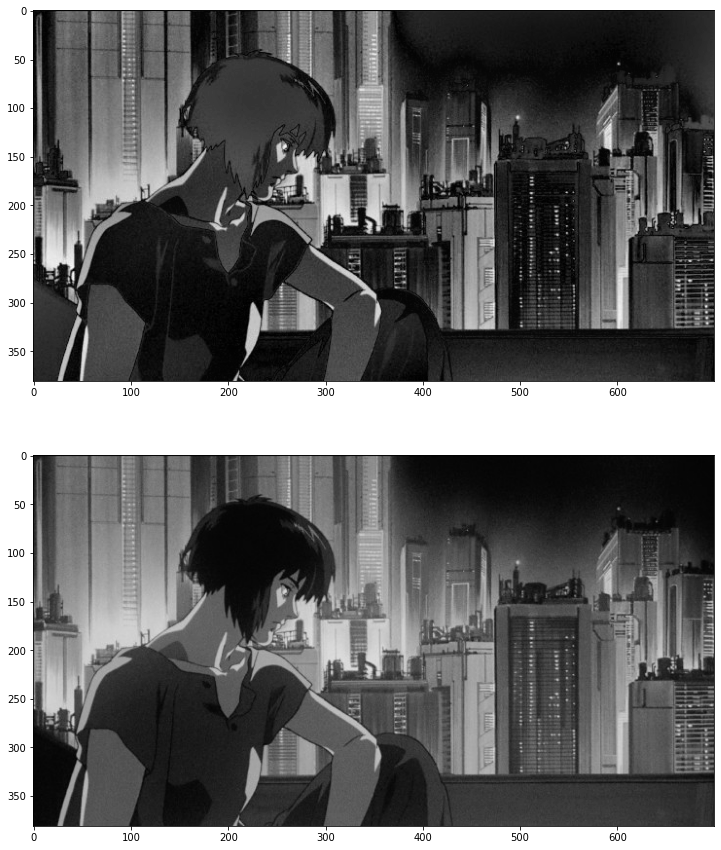

In [23]:
# Ploting in grayscale with matplotlib #
fname = 'images/motoko.jpg'
image = Image.open(fname).convert("L")
arr = np.asarray(image)

img_filtered = homo_filter(img, 30, 10, 5, 5)
f, ax = plt.subplots(2, 1,figsize=(15,15))

ax[0].imshow(img_filtered, cmap='gray')
ax[1].imshow(arr, cmap='gray', vmin=0, vmax=255)

plt.savefig('caai.png')
plt.show()